# S2RA-2023_write_ETBF_zarr

**Date:** <br>
3 - 27 April 2023 <br>
**Background:** <br>
Issue - https://github.com/Thomas-Moore-Creative/NCI-ACCESS-S2-ARD/issues/8 <br>
**Author(s):**<br>
Thomas Moore<br>

## We are using NCI ARE

In [1]:
Author1 = {"name": "Thomas Moore", "affiliation": "CSIRO", "email": "thomas.moore@csiro.au", "orcid": "0000-0003-3930-1946"}

In [2]:
import xarray as xr
import numpy as np
import xesmf as xe
import scipy
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import os
import re
import cartopy.crs as ccrs
import proplot as pplt
from rechunker import rechunk
%config Completer.use_jedi = False

## import helper

In [3]:
import importlib.util
spec = importlib.util.spec_from_file_location("helper", "/g/data/v14/tm4888/code/helper-py/helper_tools.py")
helper = importlib.util.module_from_spec(spec)
spec.loader.exec_module(helper)

# ARE cluster

In [4]:
import dask.config
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster
walltime = '02:00:00'
cores = 48
memory = '192GB'
  
cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory),processes=cores,
                     job_extra=['-q normal','-P xv83','-l ncpus='+str(cores),'-l mem='+str(memory),
                                '-l storage=gdata/xv83+gdata/v14+gdata/ux62+scratch/xv83+gdata/rt52+gdata/ik11+gdata/cj50+gdata/jk72+gdata/hh5'],
                     local_directory='$TMPDIR',
                     header_skip=["select"])
cluster.scale(jobs=4)

/g/data/v14/tm4888/miniconda3/envs/pangeo_hpc/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile
/g/data/v14/tm4888/miniconda3/envs/pangeo_hpc/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34255 instead
  warnings.warn(


In [5]:
client = Client(cluster)

In [12]:
client

<Client: 'tcp://10.6.121.15:33257' processes=192 threads=192, memory=716.16 GiB>

# or start a local cluster

In [4]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

In [5]:
print(client)

<Client: 'tcp://127.0.0.1:40525' processes=7 threads=28, memory=125.20 GiB>


# do we still need this preprocess functions or did BOM / NCI address the issue raised?

# Appears the "2015 fix" is no longer needed?
### define preprocess drop function
##### this unfortunately removes useful information like areau that's missing from 2015 files

In [13]:
def fix_SSHname(ds):
    if 'ssh' in ds.data_vars:
        ds = ds.rename({'ssh':'ssh_corrected'})
    return ds

# "T-grid" variables // SST, SSS, SSH, MLD1-2,d20,HC300,td

### load the whole timeseries using `fix_SSHname` preproccessor where needed

In [14]:
%%time
ds_SST = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/sst/mo_sst_*.nc',parallel=True)

CPU times: user 49 s, sys: 3.03 s, total: 52 s
Wall time: 2min 7s


In [15]:
%%time
ds_SSS = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/sss/mo_sss_*.nc',parallel=True)

CPU times: user 7.19 s, sys: 803 ms, total: 7.99 s
Wall time: 13.7 s


In [16]:
%%time
ds_SSH = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/ssh_corrected/mo_ssh_corrected_*.nc',parallel=True,preprocess=fix_SSHname)

CPU times: user 49 s, sys: 2.31 s, total: 51.3 s
Wall time: 1min 55s


In [17]:
%%time
ds_mld1 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/mld1/mo_mld1_*.nc',parallel=True)

CPU times: user 10.9 s, sys: 894 ms, total: 11.8 s
Wall time: 20.4 s


In [18]:
%%time
ds_mld2 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/mld2/mo_mld2_*.nc',parallel=True)

CPU times: user 7.08 s, sys: 705 ms, total: 7.79 s
Wall time: 12.6 s


In [19]:
%%time
ds_D20 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/d20/mo_d20_*.nc',parallel=True)

CPU times: user 6.34 s, sys: 617 ms, total: 6.95 s
Wall time: 10.6 s


In [20]:
%%time
ds_hc300 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/hc300/mo_hc300_*.nc',parallel=True)

CPU times: user 6.82 s, sys: 687 ms, total: 7.51 s
Wall time: 12 s


In [21]:
%%time
ds_td = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/td/mo_td_*.nc',parallel=True)

CPU times: user 7.85 s, sys: 767 ms, total: 8.61 s
Wall time: 13.4 s


In [22]:
%%time
ds_temp = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/temp/mo_temp_*.nc',parallel=True)

CPU times: user 8.18 s, sys: 775 ms, total: 8.95 s
Wall time: 13.1 s


In [23]:
ds_temp50 = ds_temp.sel(deptht=50,method='nearest').rename({'temp':'temp50'})
ds_temp100 = ds_temp.sel(deptht=100,method='nearest').rename({'temp':'temp100'})
ds_temp200 = ds_temp.sel(deptht=200,method='nearest').rename({'temp':'temp200'})
ds_temp500 = ds_temp.sel(deptht=500,method='nearest').rename({'temp':'temp500'})

## remove SSH as new data has QC issues

In [24]:
#some model variables need a squeeze, some don't
ds_ACCESS_S2_RA_ocean = xr.merge([ds_temp50.drop('deptht'),
                                  ds_temp100.drop('deptht'),
                                  ds_temp200.drop('deptht'),
                                  ds_temp500.drop('deptht'),
                                  ds_SST.squeeze(),
                                  ds_SSS.squeeze(),
                                  ds_mld1,
                                  ds_mld2,
                                  ds_D20,
                                  ds_hc300,
                                  ds_td
                                 ],compat='override')
ds_ACCESS_S2_RA_ocean = ds_ACCESS_S2_RA_ocean.drop('time_counter_bnds')
ds_ACCESS_S2_RA_ocean = ds_ACCESS_S2_RA_ocean.drop('deptht')
ds_ACCESS_S2_RA_ocean

<xarray.Dataset>
Dimensions:        (time_counter: 507, y: 1021, x: 1442, ndepth_bounds: 2, ncorners: 4)
Coordinates:
    nav_lat        (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 1981-01-16T12:00:00 ... 2023...
Dimensions without coordinates: y, x, ndepth_bounds, ncorners
Data variables: (12/15)
    areat          (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    deptht_bounds  (time_counter, ndepth_bounds) float32 dask.array<chunksize=(12, 2), meta=np.ndarray>
    latt_bounds    (time_counter, y, x, ncorners) float32 dask.array<chunksize=(12, 1021, 1442, 4), meta=np.ndarray>
    lont_bounds    (time_counter, y, x, ncorners) float32 dask.array<chunksize=(12, 1021, 1442, 4), meta=np.ndarray>
    temp50         (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    temp100        (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    ...             ...
    sss            (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    mld1           (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    mld2           (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    d20            (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    hc300          (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    td             (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    production:   An IPSL model
    TimeStamp:    12/09/2018 08:38:02 -0000
    NCO:          netCDF Operators version 4.7.7 (Homepage = http://nco.sf.ne...
    history:      Tue Apr  2 18:06:48 2019: ncatted -a history,global,d,, mo_...

### SSH has problems // ValueError: cannot reindex or align along dimension 'time_counter' because the index has duplicate values

In [25]:
ds_SSH

<xarray.Dataset>
Dimensions:            (time_counter: 507, y: 1021, x: 1442, ncorners: 4, tbnds: 2)
Coordinates:
    nav_lat            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    nav_lon            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
  * time_counter       (time_counter) datetime64[ns] 1981-01-16T12:00:00 ... ...
Dimensions without coordinates: y, x, ncorners, tbnds
Data variables:
    areat              (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    latt_bounds        (time_counter, y, x, ncorners) float32 dask.array<chunksize=(12, 1021, 1442, 4), meta=np.ndarray>
    lont_bounds        (time_counter, y, x, ncorners) float32 dask.array<chunksize=(12, 1021, 1442, 4), meta=np.ndarray>
    ssh_corrected      (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    time_counter_bnds  (time_counter, tbnds) datetime64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    production:   An IPSL model
    TimeStamp:    12/09/2018 08:38:02 -0000
    NCO:          netCDF Operators version 4.7.7 (Homepage = http://nco.sf.ne...
    history:      Tue Apr  2 17:05:20 2019: ncatted -a history,global,d,, mo_...
    correction:   Correction to the file so that the weighed average SSH is z...

In [26]:
ds_SSH.time_counter[503:505]

<xarray.DataArray 'time_counter' (time_counter: 2)>
array(['2022-12-01T12:00:00.000000000', '2022-12-01T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2022-12-01T12:00:00 2022-12-0...
Attributes:
    axis:           T
    standard_name:  time
    title:          Time
    long_name:      Time axis
    time_origin:     1981-JAN-01 00:00:00
    bounds:         time_counter_bnds
    cell_methods:   time_counter: mean

## NO LONGER REQUIRED GIVEN FIX TO 2015 DATA FILES // add back in key metadata

# rename time and lat/lon

In [27]:
ds_ACCESS_S2_RA_ocean = ds_ACCESS_S2_RA_ocean.rename({'time_counter':'time'})

In [28]:
ds_ACCESS_S2_RA_ocean = ds_ACCESS_S2_RA_ocean.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
ds_ACCESS_S2_RA_ocean

<xarray.Dataset>
Dimensions:        (time: 507, y: 1021, x: 1442, ndepth_bounds: 2, ncorners: 4)
Coordinates:
    lat            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    lon            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
  * time           (time) datetime64[ns] 1981-01-16T12:00:00 ... 2023-03-01T1...
Dimensions without coordinates: y, x, ndepth_bounds, ncorners
Data variables: (12/15)
    areat          (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    deptht_bounds  (time, ndepth_bounds) float32 dask.array<chunksize=(12, 2), meta=np.ndarray>
    latt_bounds    (time, y, x, ncorners) float32 dask.array<chunksize=(12, 1021, 1442, 4), meta=np.ndarray>
    lont_bounds    (time, y, x, ncorners) float32 dask.array<chunksize=(12, 1021, 1442, 4), meta=np.ndarray>
    temp50         (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    temp100        (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    ...             ...
    sss            (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    mld1           (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    mld2           (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    d20            (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    hc300          (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    td             (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    production:   An IPSL model
    TimeStamp:    12/09/2018 08:38:02 -0000
    NCO:          netCDF Operators version 4.7.7 (Homepage = http://nco.sf.ne...
    history:      Tue Apr  2 18:06:48 2019: ncatted -a history,global,d,, mo_...

In [29]:
ds_ACCESS_S2_RA_ocean.nbytes/1e9

59.727544288

# Deal with inconsistant and crazy "times" across collection of S2 netcdf files

In [30]:
S2_time_df = ds_ACCESS_S2_RA_ocean.time.to_dataframe()
truncated_S2_time = pd.to_datetime(S2_time_df.time).dt.date
year_month_day_strings = [ string[:-2]+'15' for string in truncated_S2_time.astype(str) ]
new_S2_datetime = pd.to_datetime(year_month_day_strings)
#replace time with cleaned version
ds_ACCESS_S2_RA_ocean['time'] = new_S2_datetime

# SAVE ocean tgrid zarr file

### rechunk to make chunks consistent

In [31]:
ds_ACCESS_S2_RA_ocean = ds_ACCESS_S2_RA_ocean.chunk({"x": 1442, "y": 1021,"time":12})

In [32]:
ds_ACCESS_S2_RA_ocean

<xarray.Dataset>
Dimensions:        (time: 507, y: 1021, x: 1442, ndepth_bounds: 2, ncorners: 4)
Coordinates:
    lat            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    lon            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
  * time           (time) datetime64[ns] 1981-01-15 1981-02-15 ... 2023-03-15
Dimensions without coordinates: y, x, ndepth_bounds, ncorners
Data variables: (12/15)
    areat          (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    deptht_bounds  (time, ndepth_bounds) float32 dask.array<chunksize=(12, 2), meta=np.ndarray>
    latt_bounds    (time, y, x, ncorners) float32 dask.array<chunksize=(12, 1021, 1442, 4), meta=np.ndarray>
    lont_bounds    (time, y, x, ncorners) float32 dask.array<chunksize=(12, 1021, 1442, 4), meta=np.ndarray>
    temp50         (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    temp100        (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    ...             ...
    sss            (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    mld1           (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    mld2           (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    d20            (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    hc300          (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    td             (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    production:   An IPSL model
    TimeStamp:    12/09/2018 08:38:02 -0000
    NCO:          netCDF Operators version 4.7.7 (Homepage = http://nco.sf.ne...
    history:      Tue Apr  2 18:06:48 2019: ncatted -a history,global,d,, mo_...

In [31]:
%%time
ds_ACCESS_S2_RA_ocean.to_zarr(store = '/g/data/xv83/users/tm4888/data/ACCESS-S2/2023_accessS2_update/Node4_accessS2.RA.ocean.nativeTgrid.zarr',consolidated=True)

KilledWorker: ("('open_dataset-concatenate-concatenate-655507e155bb31ca72f94c49a16638a9', 25, 0, 0, 0)", <WorkerState 'tcp://10.6.77.71:34619', name: PBSCluster-1-15, status: closed, memory: 0, processing: 1>)

# Check if zarr collections exist in `/g/data/v14/tm4888/data/ACCESS-S2/` and skip above
# $\Downarrow$

In [45]:
ds_ACCESS_S2_RA_ocean_nativeTgrid = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.nativeTgrid.zarr',consolidated=True)

CPU times: user 962 ms, sys: 124 ms, total: 1.09 s
Wall time: 3.4 s


Text(0.5, 1.0, 'ssh')

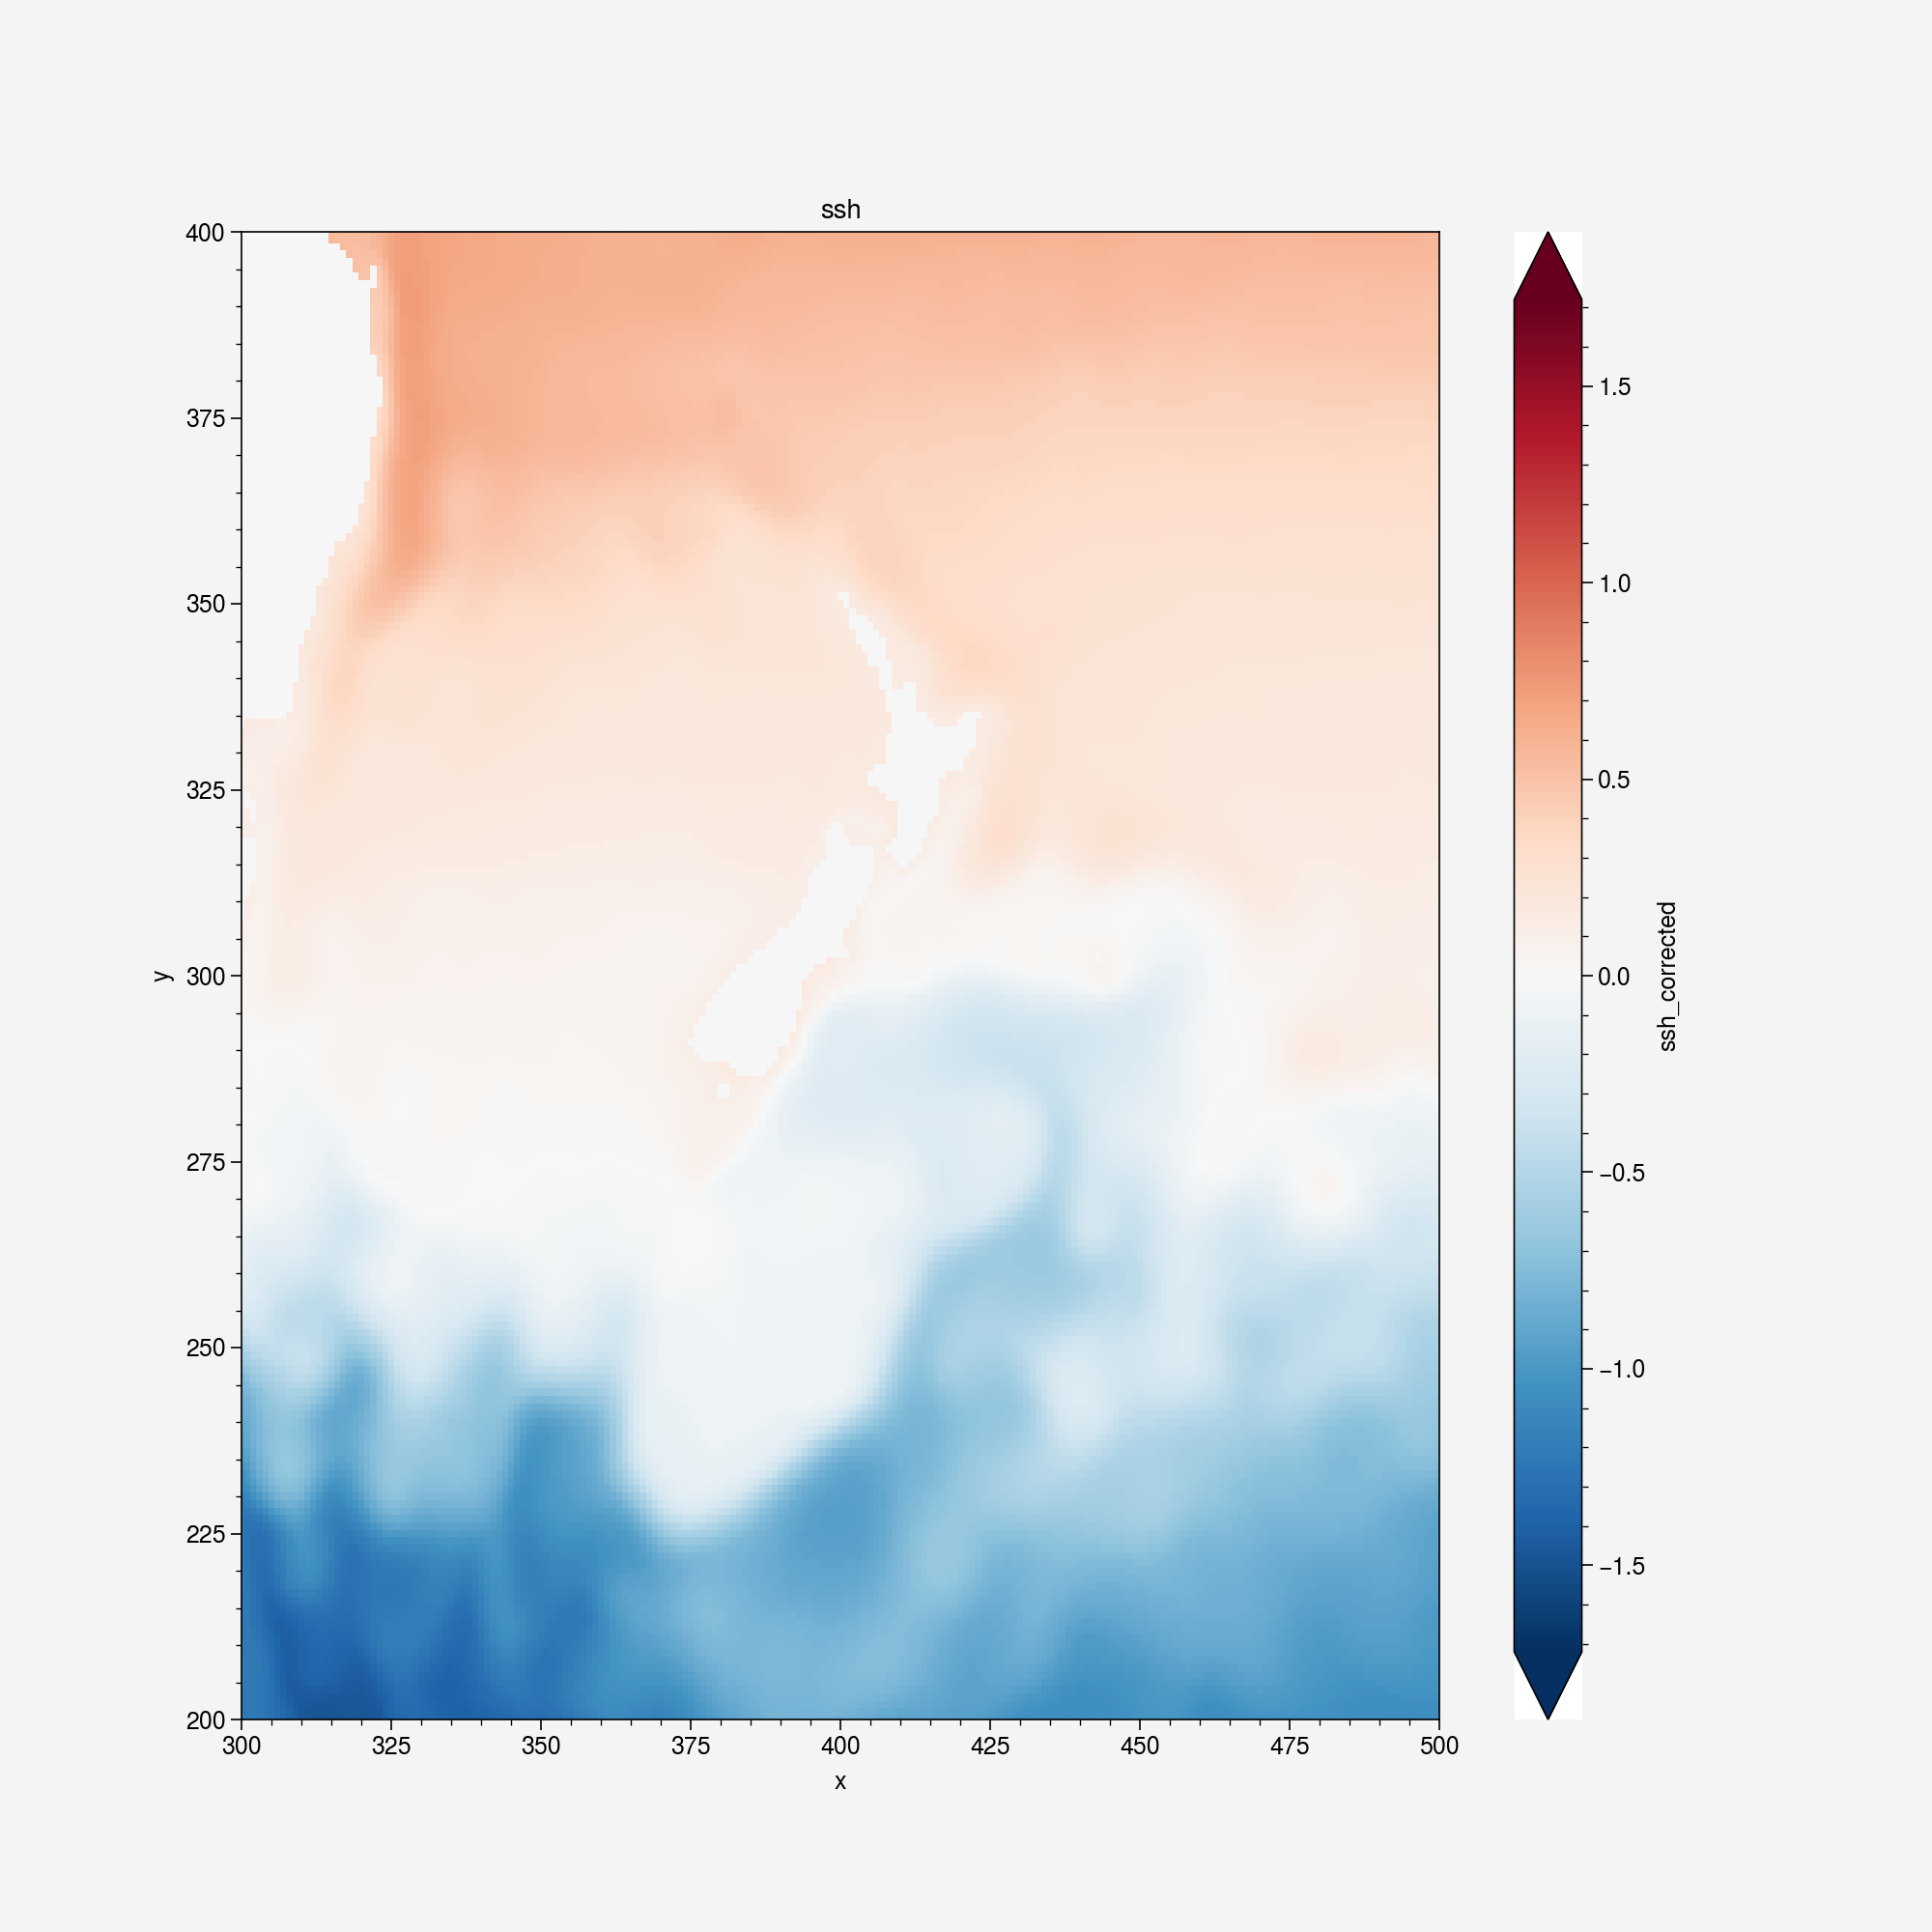

In [47]:
%%time
ds_ACCESS_S2_RA_ocean_nativeTgrid.ssh_corrected.mean('time').plot(robust=True)
fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.ylim([200, 400])
plt.xlim([300, 500])
plt.xlabel('x')
plt.ylabel('y')
plt.title('ssh')

# file size

In [48]:
ds_ACCESS_S2_RA_ocean_nativeTgrid.nbytes/1e9

34.787083032

# U & V

# Check if zarr collections exist in `/g/data/v14/tm4888/data/ACCESS-S2/` and skip arrows if you can
# $\Downarrow$

# ACCESS-S2 ocean reanalysis (RA) 1981 - 2018

# load U & V S2_RA

In [7]:
%%time
# define preprocess drop function - this unfortunately removes useful information like areau that's missing from 2015 files
def drop_not_in_2015(ds):
    if 'latu_bounds' in ds.data_vars:
        ds = ds.drop(['latu_bounds'])
    if 'lonu_bounds' in ds.data_vars:
        ds = ds.drop(['lonu_bounds'])
    if 'latv_bounds' in ds.data_vars:
        ds = ds.drop(['latv_bounds'])
    if 'lonv_bounds' in ds.data_vars:
        ds = ds.drop(['lonv_bounds'])
    if 'depthu_bounds' in ds.data_vars:
        ds = ds.drop(['depthu_bounds'])
    if 'areau' in ds.data_vars:
        ds = ds.drop(['areau'])
    if 'depthv_bounds' in ds.data_vars:
        ds = ds.drop(['depthv_bounds'])
    if 'areav' in ds.data_vars:
        ds = ds.drop(['areav'])    
    return ds
ds_u = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/u/mo_u_*.nc',parallel=True,preprocess=drop_not_in_2015)
ds_u

CPU times: user 9.34 s, sys: 2.3 s, total: 11.6 s
Wall time: 36.8 s


<xarray.Dataset>
Dimensions:            (depthu: 75, y: 1021, x: 1442, time_counter: 492, tbnds: 2)
Coordinates:
  * depthu             (depthu) float32 0.5058 1.556 ... 5.698e+03 5.902e+03
    nav_lat            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    nav_lon            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
  * time_counter       (time_counter) datetime64[ns] 1981-01-16T12:00:00 ... ...
Dimensions without coordinates: y, x, tbnds
Data variables:
    time_counter_bnds  (time_counter, tbnds) datetime64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
    u                  (time_counter, depthu, y, x) float32 dask.array<chunksize=(12, 75, 1021, 1442), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    production:   An IPSL model
    TimeStamp:    12/09/2018 08:37:54 -0000
    NCO:          netCDF Operators version 4.7.7 (Homepage = http://nco.sf.ne...
    history:      Tue Apr  2 18:39:39 2019: ncatted -a history,global,d,, mo_...

In [8]:
%%time
# define preprocess drop function - this unfortunately removes useful information like areau that's missing from 2015 files
def drop_not_in_2015(ds):
    if 'latu_bounds' in ds.data_vars:
        ds = ds.drop(['latu_bounds'])
    if 'lonu_bounds' in ds.data_vars:
        ds = ds.drop(['lonu_bounds'])
    if 'latv_bounds' in ds.data_vars:
        ds = ds.drop(['latv_bounds'])
    if 'lonv_bounds' in ds.data_vars:
        ds = ds.drop(['lonv_bounds'])
    if 'depthu_bounds' in ds.data_vars:
        ds = ds.drop(['depthu_bounds'])
    if 'areau' in ds.data_vars:
        ds = ds.drop(['areau'])
    if 'depthv_bounds' in ds.data_vars:
        ds = ds.drop(['depthv_bounds'])
    if 'areav' in ds.data_vars:
        ds = ds.drop(['areav'])    
    return ds
ds_v = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/v/mo_v_*.nc',parallel=True,preprocess=drop_not_in_2015)
ds_v

CPU times: user 6.54 s, sys: 1.45 s, total: 7.99 s
Wall time: 19.4 s


<xarray.Dataset>
Dimensions:            (depthv: 75, y: 1021, x: 1442, time_counter: 492, tbnds: 2)
Coordinates:
  * depthv             (depthv) float32 0.5058 1.556 ... 5.698e+03 5.902e+03
    nav_lat            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    nav_lon            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
  * time_counter       (time_counter) datetime64[ns] 1981-01-16T12:00:00 ... ...
Dimensions without coordinates: y, x, tbnds
Data variables:
    time_counter_bnds  (time_counter, tbnds) datetime64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
    v                  (time_counter, depthv, y, x) float32 dask.array<chunksize=(12, 75, 1021, 1442), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    production:   An IPSL model
    TimeStamp:    12/09/2018 08:37:34 -0000
    NCO:          netCDF Operators version 4.7.7 (Homepage = http://nco.sf.ne...
    history:      Tue Apr  2 18:08:10 2019: ncatted -a history,global,d,, mo_...

# THIS IS LOST BELOW IN RECHUNKING add missing area metdata back in

In [10]:
ds_u = xr.combine_by_coords([ds_u,areau])
ds_v = xr.combine_by_coords([ds_v,areav])

# Deal with the same depth coordinates given two different names & rename time

In [11]:
ds_u = ds_u.rename({'depthu':'depth','time_counter':'time'})
ds_v = ds_v.rename({'depthv':'depth','time_counter':'time'})

# rename lat/lon

In [12]:
ds_u = ds_u.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
ds_v = ds_v.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})

# Deal with inconsistant and crazy dates (use time from Tgrid zarr already corrected)

In [13]:
new_time = ds_ACCESS_S2_RA_ocean_nativeTgrid.time

In [14]:
ds_u['time'] = new_time
ds_v['time'] = new_time

In [15]:
ds_u

<xarray.Dataset>
Dimensions:            (y: 1021, x: 1442, depth: 75, time: 492, tbnds: 2)
Coordinates:
    lat                (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    lon                (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
  * depth              (depth) float32 0.5058 1.556 ... 5.698e+03 5.902e+03
  * time               (time) datetime64[ns] 1981-01-15 ... 2021-12-15
Dimensions without coordinates: y, x, tbnds
Data variables:
    areau              (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    time_counter_bnds  (time, tbnds) datetime64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
    u                  (time, depth, y, x) float32 dask.array<chunksize=(12, 75, 1021, 1442), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    production:   An IPSL model
    TimeStamp:    12/09/2018 08:37:54 -0000
    NCO:          netCDF Operators version 4.7.7 (Homepage = http://nco.sf.ne...
    history:      Tue Apr  2 18:39:39 2019: ncatted -a history,global,d,, mo_...

# Double Check for bugged time stamps

In [16]:
u_time = ds_u.time.values
v_time = ds_v.time.values
ds_ACCESS_S2_RA_ocean_nativeTgrid_time = ds_ACCESS_S2_RA_ocean_nativeTgrid.time.values

In [17]:
compare_UV = (u_time == v_time)
np.where(compare_UV==False)

(array([], dtype=int64),)

In [18]:
u_time[236]

numpy.datetime64('2000-09-15T00:00:00.000000000')

In [19]:
v_time[236]

numpy.datetime64('2000-09-15T00:00:00.000000000')

In [20]:
ds_ACCESS_S2_RA_ocean_nativeTgrid_time[236]

numpy.datetime64('2000-09-15T00:00:00.000000000')

In [21]:
u_time[329]

numpy.datetime64('2008-06-15T00:00:00.000000000')

In [22]:
v_time[329]

numpy.datetime64('2008-06-15T00:00:00.000000000')

In [23]:
ds_ACCESS_S2_RA_ocean_nativeTgrid_time[329]

numpy.datetime64('2008-06-15T00:00:00.000000000')

# Checks out

# drop `time_counter_bounds` var

In [24]:
ds_u = ds_u.drop('time_counter_bnds')
ds_v = ds_v.drop('time_counter_bnds')

# re-chunk with rechunker!
# and write out native grid U & V zarr collections

In [25]:
ds_u = ds_u[['u','areau']]
# not sure this encoding reset is needed #
for var in ds_u.variables:
        ds_u[var].encoding = {}

In [26]:
ds_u

<xarray.Dataset>
Dimensions:  (time: 492, depth: 75, y: 1021, x: 1442)
Coordinates:
    lat      (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
  * depth    (depth) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * time     (time) datetime64[ns] 1981-01-15 1981-02-15 ... 2021-12-15
Dimensions without coordinates: y, x
Data variables:
    u        (time, depth, y, x) float32 dask.array<chunksize=(12, 75, 1021, 1442), meta=np.ndarray>
    areau    (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    production:   An IPSL model
    TimeStamp:    12/09/2018 08:37:54 -0000
    NCO:          netCDF Operators version 4.7.7 (Homepage = http://nco.sf.ne...
    history:      Tue Apr  2 18:39:39 2019: ncatted -a history,global,d,, mo_...

In [28]:
%%time
target_chunks = {
        'u': {'time':492,'depth':1,'x':250,'y':250},
        'areau':{'x':1442,'y':1021},
        'time': None,
        'depth': None}

mem_max = '10GB'

target_store = '/g/data/v14/tm4888/data/ACCESS-S2/.rechunker/group_rechunked.zarr'
temp_store = '/g/data/v14/tm4888/data/ACCESS-S2/.rechunker/group_rechunked-tmp.zarr'
! rm -rf /g/data/v14/tm4888/data/ACCESS-S2/.rechunker/*.zarr

array_plan = rechunk(ds_u, target_chunks, mem_max, target_store,temp_store=temp_store)
rechunked_result = array_plan.execute()
print('final chunking scheme:'+str(rechunked_result.u.chunks))
ds_u_rechunked = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/.rechunker/group_rechunked.zarr',
                             consolidated=False)
! rm -rf /g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.u.nativeUgrid.zarr
ds_u_rechunked.to_zarr(store = '/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.u.nativeUgrid.zarr',
                                         consolidated=True)

final chunking scheme:(492, 1, 250, 250)
CPU times: user 1min 26s, sys: 8.66 s, total: 1min 35s
Wall time: 6min 57s


In [31]:
ds_v = ds_v[['v','areav']]
# not sure this encoding reset is needed #
for var in ds_v.variables:
        ds_v[var].encoding = {}

In [33]:
%%time
target_chunks = {
        'v': {'time':492,'depth':1,'x':250,'y':250},
        'areav':{'x':1442,'y':1021},
        'time': None,
        'depth': None}

mem_max = '10GB'

target_store = '/g/data/v14/tm4888/data/ACCESS-S2/.rechunker/group_rechunked.zarr'
temp_store = '/g/data/v14/tm4888/data/ACCESS-S2/.rechunker/group_rechunked-tmp.zarr'
! rm -rf /g/data/v14/tm4888/data/ACCESS-S2/.rechunker/*.zarr

array_plan = rechunk(ds_v, target_chunks, mem_max, target_store,temp_store=temp_store)
rechunked_result = array_plan.execute()
print('final chunking scheme:'+str(rechunked_result.v.chunks))
ds_v_rechunked = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/.rechunker/group_rechunked.zarr',
                             consolidated=False)
#! rm -rf /g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.v.nativeVgrid.zarr
ds_v_rechunked.to_zarr(store = '/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.v.nativeVgrid.zarr',
                                         consolidated=True)

final chunking scheme:(492, 1, 250, 250)
CPU times: user 1min 31s, sys: 9.28 s, total: 1min 41s
Wall time: 7min 31s


# $\Downarrow$
# CAN SKIP TO THIS STEP IF U & V `ZARR` FILES ARE WRITTEN AND AVAILABLE
hard part for u & v done above

In [35]:
u = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.u.nativeUgrid.zarr',consolidated=True)
v = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.v.nativeVgrid.zarr',consolidated=True)

# $ The\ End$

# Break glass in case of emergency
# $\Downarrow$

In [30]:
client.restart()

<Client: 'tcp://10.0.128.157:39187' processes=7 threads=14, memory=306.39 GiB>

In [33]:
client.shutdown()

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


In [ ]:
client.restart()